Данный ноутбук представляет собой небольшое исследование применения алгоритмов многокритериальной оптимизации для задачи оптимизации криптовалютного портфеля.

# Crypto Portfolio Optimization

In [1]:
# Библиотеки для многокритериальной оптимизации
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.ctaea import CTAEA

from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

# Библиотека для рассчета гиперобъема
from deap.tools._hypervolume import hv

# Библиотека для рассчета расстояний между точками
from scipy.spatial.distance import pdist

# Библиотеки для работы с данными
import numpy as np
import pandas as pd
from scipy.stats import norm

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для работы с датой и временем
from datetime import datetime, timedelta

# Библиотека для работы с информацией о криптовалютах
import yfinance as yf

sns.set_style('darkgrid')

В качестве метрики для оценки риска криптовалютного портфеля мы будем использовать его валатильность + несколько штрафных функций, чтобы алгоритм не "клал все яйца в одну корзину".


Для оценки доходности будем использовать разницу между ценой портфеля на конец периода и ценой на начало периода.

In [2]:
# Создадим функцию для получения цены на указанную дату
def get_price_on_date(ticker_symbol: str, date_str: str) -> float | None:
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
        end_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')
        
        data = yf.Ticker(ticker_symbol).history(start=date_str, end=end_date)
        
        if data.empty:
            print(f"No data available for {ticker_symbol} on {date_str}")
            return None
            
        return round(float(data['Close'].iloc[0]), 2)
    except Exception as e:
        print(f"Error fetching price for {ticker_symbol}: {e}")
        return None

In [3]:
def calculate_portfolio_price(portfolio: dict[str, float],
                            start_date: str, end_date: str, 
                            start_sum: float = 100) -> float:
    """Расчет цены портфеля на указанную дату."""
    
    portfolio_parts = {ticker: float((start_sum * part) / get_price_on_date(ticker, start_date)) 
                        for ticker, part in portfolio.items()}
    
    end_prices = {ticker: get_price_on_date(ticker, end_date) * portfolio_parts[ticker] for ticker in portfolio_parts.keys()}
    return round(sum(end_prices.values()), 2)

In [13]:
# Загрузим историю изменения цены криптовалюты

# Список интересующих криптовалют можно изменять. Все доступные тикеры можно посмотреть на https://finance.yahoo.com/crypto/
TICKERS = ["TON11419-USD", "SUI20947-USD",'ETH-USD', "LINK-USD", "APT21794-USD", "FET-USD", "TAO22974-USD", 'BTC-USD']

training_start_date = "2024-08-01"
training_end_date = "2024-08-29"

start_tocken_prices = {ticker: get_price_on_date(ticker, training_start_date) for ticker in TICKERS}
end_tocken_prices = {ticker: get_price_on_date(ticker, training_end_date) for ticker in TICKERS}

data: pd.DataFrame = yf.download(TICKERS, start=training_start_date, end=training_end_date, progress=True)["Adj Close"]
returns: pd.DataFrame = data.pct_change().dropna()

# Для рассчета ожидаемой доходности и ковариационной матрицы используется средняя доходность
expected_returns: pd.Series = returns.mean()
cov_matrix: pd.DataFrame = returns.cov()

[*********************100%***********************]  8 of 8 completed


In [37]:
# Класс для решения задачи многокритериальной оптимизации криптовалютного портфеля
class CryptoPortfolioProblem(ElementwiseProblem):
    """Задача многокритериальной оптимизации криптовалютного портфеля."""
    
    START_PRICE = 1000.0
    PENALTY_FACTOR = 0.3
    
    def __init__(self, 
                elementwise=True, 
                **kwargs):
        """
        Инициализация задачи оптимизации.
        
        Args:
            elementwise (bool): Флаг поэлементной оценки
            confidence_level (float): Уровень доверия для VaR
            **kwargs: Дополнительные параметры
        """
        n_assets = len(TICKERS)
        
        # Предварительный расчет статических данных
        self._precompute_data()
        
        super().__init__(
            elementwise=elementwise,
            n_var=n_assets,
            n_obj=2,
            xl=0,
            xu=1
        )

    def _precompute_data(self):
        """Предварительный расчет данных для оптимизации производительности."""
        self.start_token_prices = np.array([start_tocken_prices[ticker] for ticker in TICKERS])
        self.end_token_prices = np.array([end_tocken_prices[ticker] for ticker in TICKERS])
        self.cov_matrix = cov_matrix.values

    @staticmethod
    def _normalize_weights(x: np.ndarray) -> np.ndarray:
        """Нормализация весов портфеля."""
        return x / np.sum(x)

    def _evaluate(self, x: np.ndarray, out: dict, *args, **kwargs) -> None:
        """
        Оценка целевых функций.
        
        Args:
            x: Веса портфеля
            out: Словарь результатов
        """
        weights = self._normalize_weights(x)
        profit = self._calc_portfolio_return(weights)
        risk = self._calc_volatility(weights)
        
        out["F"] = [-profit, risk]

    def _calc_portfolio_return(self, weights: np.ndarray) -> float:
        """Расчет доходности портфеля."""
        portfolio_units = weights * self.START_PRICE / self.start_token_prices
        end_value = np.sum(portfolio_units * self.end_token_prices)
        return end_value - self.START_PRICE

    def _calc_volatility(self, weights: np.ndarray) -> float:
        """Расчет волатильности портфеля."""
        penalty = self.PENALTY_FACTOR * max(weights)
        return np.sqrt(weights.T @ self.cov_matrix @ weights) + penalty
            
problem = CryptoPortfolioProblem()

# Применяем алгоритмы многокритериальной оптимизации

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |      9 |             - |             -
     2 |      300 |     17 |  0.0831288299 |         ideal
     3 |      450 |     19 |  0.0892242645 |         ideal
     4 |      600 |     15 |  0.2797117500 |         ideal
     5 |      750 |     20 |  0.0189351275 |         ideal
     6 |      900 |     25 |  0.0243719510 |             f
     7 |     1050 |     43 |  0.0396403333 |         ideal
     8 |     1200 |     58 |  0.0126402566 |         ideal
     9 |     1350 |     52 |  0.0325125107 |         ideal
    10 |     1500 |     58 |  0.0031270558 |         ideal
    11 |     1650 |     62 |  0.0193145314 |         ideal
    12 |     1800 |     67 |  0.0761992375 |         ideal
    13 |     1950 |     78 |  0.0049231299 |         ideal
    14 |     2100 |     97 |  0.0907519574 |         ideal
    15 |     2250 |    108 |  0.0182492665 |         ideal
    16 |     2400 |    116 |  0.0022458269 |            

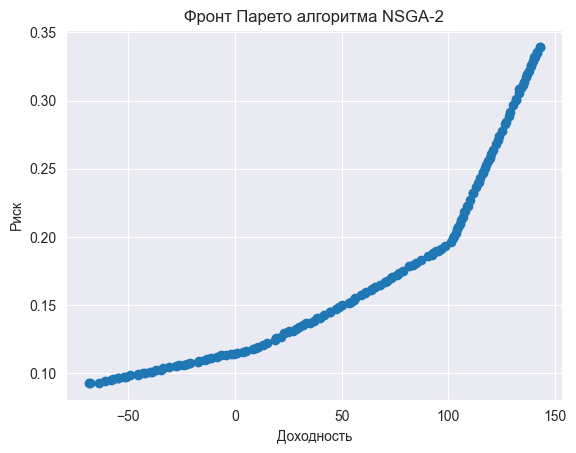

In [38]:
# Первый алгоритм, который мы протестируем - это NSGA-2.
# В данном случае мы не используем параметры по умолчанию, а явно задаем размер популяции и количество поколений

nsga2 = NSGA2(pop_size=150)
mutation = PolynomialMutation(eta=20, prob_var=0.2)

nsga2_result = minimize(
    problem,
    nsga2,
    ('n_gen', 1500),
    verbose=True,
    mutation=mutation
)

# Визуализируем результаты
plt.scatter(-nsga2_result.F[:, 0], nsga2_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма NSGA-2")
plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       51 |      9 |             - |             -
     2 |      102 |     41 |  0.6071635196 |         ideal
     3 |      153 |     46 |  0.2121992458 |         ideal
     4 |      204 |     51 |  0.1980856903 |         ideal
     5 |      255 |     51 |  0.2642129474 |         ideal
     6 |      306 |     44 |  0.0526873655 |         ideal
     7 |      357 |     22 |  0.0165893619 |         ideal
     8 |      408 |     20 |  0.1214132025 |         ideal
     9 |      459 |     37 |  0.0711949339 |         ideal
    10 |      510 |     46 |  0.0624712416 |         ideal
    11 |      561 |     51 |  0.0948431338 |         ideal
    12 |      612 |     51 |  0.0789014016 |         ideal
    13 |      663 |     30 |  0.0140999606 |         ideal
    14 |      714 |     51 |  0.0228890796 |         ideal
    15 |      765 |     51 |  0.0460940868 |         ideal
    16 |      816 |     21 |  0.0320928828 |         ide

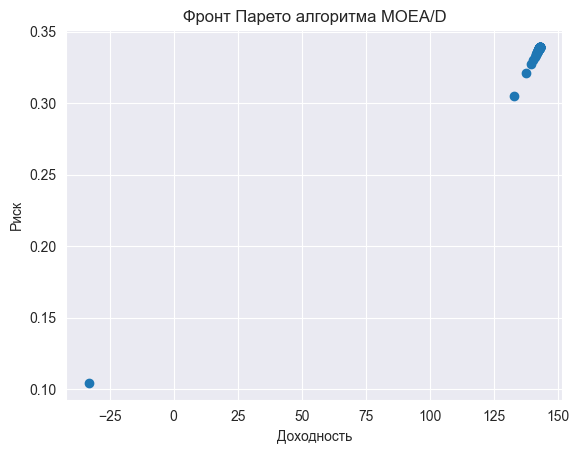

In [39]:
# Второй алгоритм, который мы протестируем - это MOEA/D.

# get_reference_directions генерирует направления для поиска MOEA/D
ref_dirs = get_reference_directions('uniform', 2, n_partitions=50)

moea_d = MOEAD(
    ref_dirs,
    n_neighbors=20,
)

moea_d_result = minimize(problem,
            moea_d,
            ('n_gen', 1500),
            verbose=True
            )

plt.scatter(-moea_d_result.F[:, 0], moea_d_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма MOEA/D")
plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       51 |      5 |             - |             -
     2 |      102 |     10 |  0.0240367385 |         ideal
     3 |      153 |     15 |  0.0516462849 |         ideal
     4 |      204 |     14 |  0.0105430899 |             f
     5 |      255 |     14 |  0.0948605883 |         ideal
     6 |      306 |     15 |  0.0102835198 |         ideal
     7 |      357 |     18 |  0.0122868542 |             f
     8 |      408 |     19 |  0.0170154974 |             f
     9 |      459 |     22 |  0.0508629704 |         ideal
    10 |      510 |     25 |  0.0497970341 |         ideal
    11 |      561 |     26 |  0.0031934545 |         ideal
    12 |      612 |     26 |  0.0114508618 |             f
    13 |      663 |     32 |  0.0079367848 |             f
    14 |      714 |     29 |  0.0078539867 |             f
    15 |      765 |     34 |  0.0172596073 |         ideal
    16 |      816 |     34 |  0.0074390526 |            

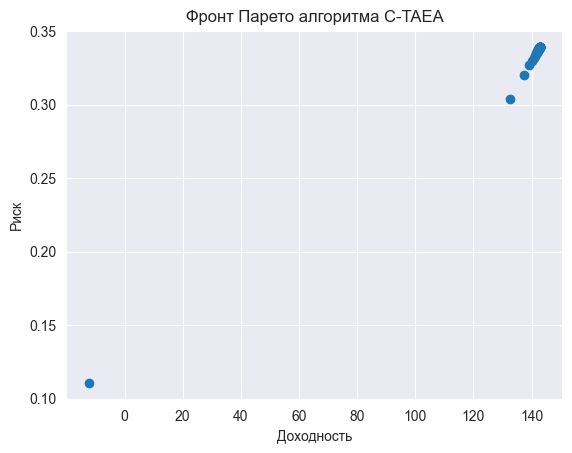

In [40]:
# Третий алгоритм, который мы протестируем - это C-TAEA.

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=50)

c_taea = CTAEA(ref_dirs=ref_dirs)

c_taea_res = minimize(problem,
            c_taea,
            ('n_gen', 1500),
            verbose=True
            )

plt.scatter(-c_taea_res.F[:, 0], c_taea_res.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма C-TAEA")
plt.show()

# Оценка полученных Парето-фронтов

In [41]:
def calculate_common_reference_point(pareto_fronts: list, margin: float = 0.1, min_margin: float = 0.01) -> np.ndarray:
    """
    Вычисляет общую референсную точку для нескольких Парето-фронтов с учётом минимального запаса.

    Аргументы:
    - pareto_fronts: list - список массивов np.ndarray, где каждый массив представляет Парето-фронт
        (размерность каждого массива: n_points x n_objectives).
    - margin: float - относительный запас, добавляемый к максимальным значениям целевых функций.
    - min_margin: float - минимальный гарантированный запас, добавляемый к каждой цели (в абсолютных величинах).

    Возвращает:
    - np.ndarray - общая референсная точка (массив размерности n_objectives).
    """
    # Объединяем все Парето-фронты в один массив
    all_points = np.vstack(pareto_fronts)

    # Находим максимальные значения для каждой целевой функции
    max_values = np.max(all_points, axis=0)
    min_values = np.min(all_points, axis=0)

    # Вычисляем диапазоны
    ranges = max_values - min_values

    # Референсная точка с учётом запаса
    reference_point = max_values + np.maximum(margin * ranges, min_margin)

    return reference_point

In [44]:
reference_point = calculate_common_reference_point([nsga2_result.F, moea_d_result.F, c_taea_res.F])

Превоначально применим метрику Hypervolume для оценки качества полученных Парето-фронтов.
В качестве reference point возьмём точку с отрицательной доходностью (-0.5) и высоким риском (1.0)

In [45]:
print('NSGA-2 hypervolume: ', hv.hypervolume(nsga2_result.F, reference_point))  
print('MOEA/D hypervolume: ', hv.hypervolume(moea_d_result.F, reference_point))
print('C-TAEA hypervolume: ', hv.hypervolume(c_taea_res.F, reference_point))

NSGA-2 hypervolume:  48.9784494400032
MOEA/D hypervolume:  24.869036720584685
C-TAEA hypervolume:  28.71669314745512


Теперь применим метрику Spacing для оценки расстояния между точками Парето-фронта.

In [47]:
def spacing(points: np.ndarray) -> float:
    distances = np.zeros(len(points))
    for i, point in enumerate(points):
        other_points = np.delete(points, i, axis=0)
        distances[i] = np.min(np.linalg.norm(other_points - point, axis=1))
    # Среднее расстояние
    mean_distance = np.mean(distances)
    # Вычисление Spacing
    spacing = np.sqrt(np.mean((distances - mean_distance) ** 2))
    return spacing

print('NSGA-2 spacing: ', spacing(nsga2_result.F))
print('MOEA/D spacing: ', spacing(moea_d_result.F))
print('C-TAEA spacing: ', spacing(c_taea_res.F))

NSGA-2 spacing:  0.6036338480569828
MOEA/D spacing:  22.99803445250265
C-TAEA spacing:  20.070303759370304


И теперь рассчитаем среднее евклидово расстояние между точками Парето-фронта для оценки разнообразия Парето-фронтов.

In [48]:
def average_distance(points: np.ndarray) -> float:
    distances = pdist(points, metric='euclidean')
    return np.mean(distances)

print('NSGA-2 average distance: ', average_distance(nsga2_result.X))
print('MOEA/D average distance: ', average_distance(moea_d_result.X))
print('C-TAEA average distance: ', average_distance(c_taea_res.X))

NSGA-2 average distance:  1.1287041612205695
MOEA/D average distance:  0.24361906994661958
C-TAEA average distance:  0.13804441520778862


# Анализ предоставленных решений

In [49]:
# Сейчас решение представлено в виде чисел от 0 до 10. Нам нужно нормализовать их так, чтобы их сумма равнялась 1.
def normalize_weights(weights: np.ndarray) -> np.ndarray:
    res = np.round(weights / weights.sum(axis=1)[:, np.newaxis], 3)
    return res

In [50]:
# Соберём данные в единую таблицу

nsga2_data = pd.DataFrame(normalize_weights(nsga2_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(nsga2_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
nsga2_data['algorithm'] = 'NSGA-2'

moea_d_data = pd.DataFrame(normalize_weights(moea_d_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(moea_d_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
moea_d_data['algorithm'] = 'MOEA/D'

c_taea_data = pd.DataFrame(normalize_weights(c_taea_res.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(c_taea_res.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
c_taea_data['algorithm'] = 'C-TAEA'

all_data = pd.concat([nsga2_data, moea_d_data, c_taea_data])
all_data['expected_profit'] = -all_data['expected_profit']
all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm
0,0.139,0.139,0.139,0.139,0.139,0.025,0.139,0.139,-68.494040,0.092742,NSGA-2
1,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,142.857140,0.339385,NSGA-2
2,0.000,0.610,0.000,0.000,0.388,0.002,0.000,0.000,110.131432,0.226950,NSGA-2
3,0.001,0.456,0.000,0.000,0.457,0.006,0.054,0.026,87.181032,0.182960,NSGA-2
4,0.000,0.424,0.000,0.000,0.422,0.019,0.134,0.000,78.916005,0.174647,NSGA-2
...,...,...,...,...,...,...,...,...,...,...,...
29,0.000,0.994,0.000,0.000,0.006,0.000,0.000,0.000,142.341952,0.337591,C-TAEA
34,0.000,0.979,0.000,0.000,0.021,0.000,0.000,0.000,141.110762,0.333305,C-TAEA
36,0.000,0.975,0.000,0.000,0.025,0.000,0.000,0.000,140.725841,0.331966,C-TAEA
43,0.000,0.878,0.000,0.000,0.122,0.000,0.000,0.000,132.630637,0.303860,C-TAEA


In [51]:
all_data.groupby('algorithm', as_index=False).mean()

,algorithm,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk
0,C-TAEA,0.000000,0.943409,0.000000,0.006591,0.027182,0.007727,0.007500,0.007591,134.203244,0.323408
1,MOEA/D,0.001182,0.943136,0.007273,0.000773,0.026182,0.007000,0.007273,0.007136,133.293880,0.323254
2,NSGA-2,0.014054,0.444953,0.018933,0.025430,0.258477,0.063248,0.115564,0.059181,56.496687,0.182614


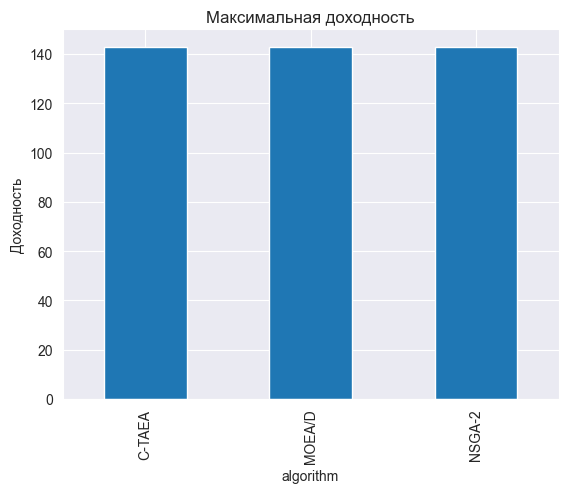

In [52]:
all_data.groupby('algorithm')['expected_profit'].max().plot(kind='bar')
plt.title('Максимальная доходность')
plt.ylabel('Доходность')

plt.show()

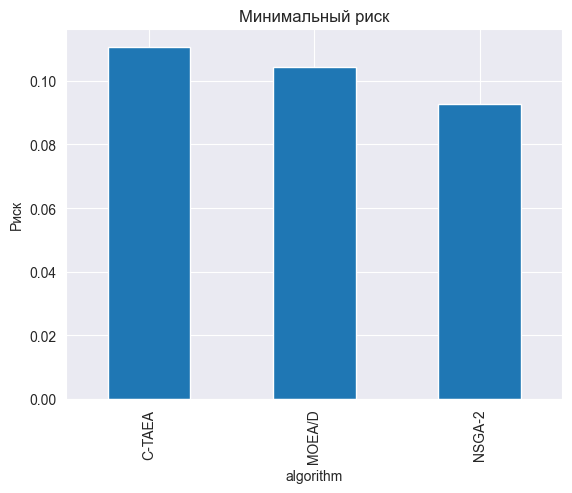

In [53]:
all_data.groupby('algorithm')['risk'].min().plot(kind='bar')
plt.title('Минимальный риск')
plt.ylabel('Риск')
plt.show()

In [54]:
all_data['end_price'] = all_data.apply(lambda row: calculate_portfolio_price(row[TICKERS].to_dict(), '2024-11-01', '2024-12-02'), axis=1)
all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm,end_price
0,0.139,0.139,0.139,0.139,0.139,0.025,0.139,0.139,-68.494040,0.092742,NSGA-2,148.00
1,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,142.857140,0.339385,NSGA-2,163.32
2,0.000,0.610,0.000,0.000,0.388,0.002,0.000,0.000,110.131432,0.226950,NSGA-2,155.40
3,0.001,0.456,0.000,0.000,0.457,0.006,0.054,0.026,87.181032,0.182960,NSGA-2,151.31
4,0.000,0.424,0.000,0.000,0.422,0.019,0.134,0.000,78.916005,0.174647,NSGA-2,149.46
...,...,...,...,...,...,...,...,...,...,...,...,...
29,0.000,0.994,0.000,0.000,0.006,0.000,0.000,0.000,142.341952,0.337591,C-TAEA,163.20
34,0.000,0.979,0.000,0.000,0.021,0.000,0.000,0.000,141.110762,0.333305,C-TAEA,162.89
36,0.000,0.975,0.000,0.000,0.025,0.000,0.000,0.000,140.725841,0.331966,C-TAEA,162.81
43,0.000,0.878,0.000,0.000,0.122,0.000,0.000,0.000,132.630637,0.303860,C-TAEA,160.85


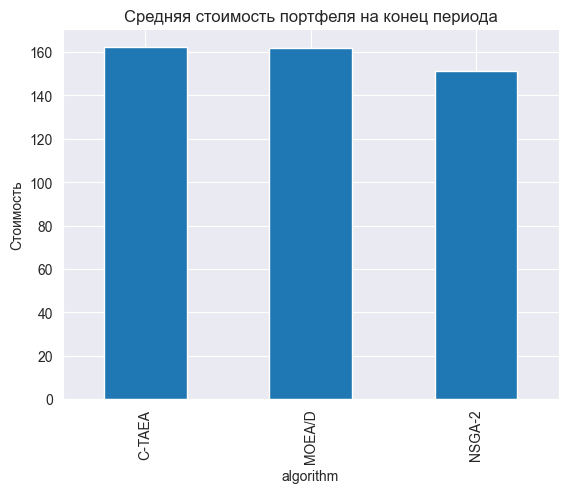

In [55]:
all_data.groupby('algorithm')['end_price'].mean().plot(kind='bar')
plt.title('Средняя стоимость портфеля на конец периода')
plt.ylabel('Стоимость')
plt.show()

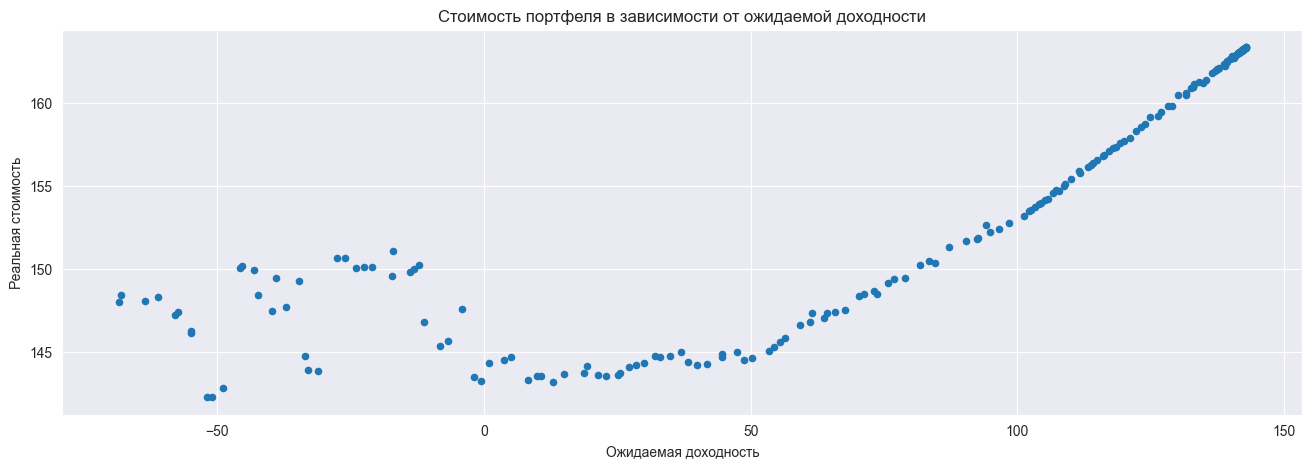

In [56]:
all_data.sort_values(by='end_price', ascending=False)[['expected_profit', 'end_price']]\
    .plot(kind='scatter', x='expected_profit', y='end_price', figsize=(16, 5))
plt.title('Стоимость портфеля в зависимости от ожидаемой доходности')
plt.xlabel('Ожидаемая доходность')
plt.ylabel('Реальная стоимость')
plt.show()

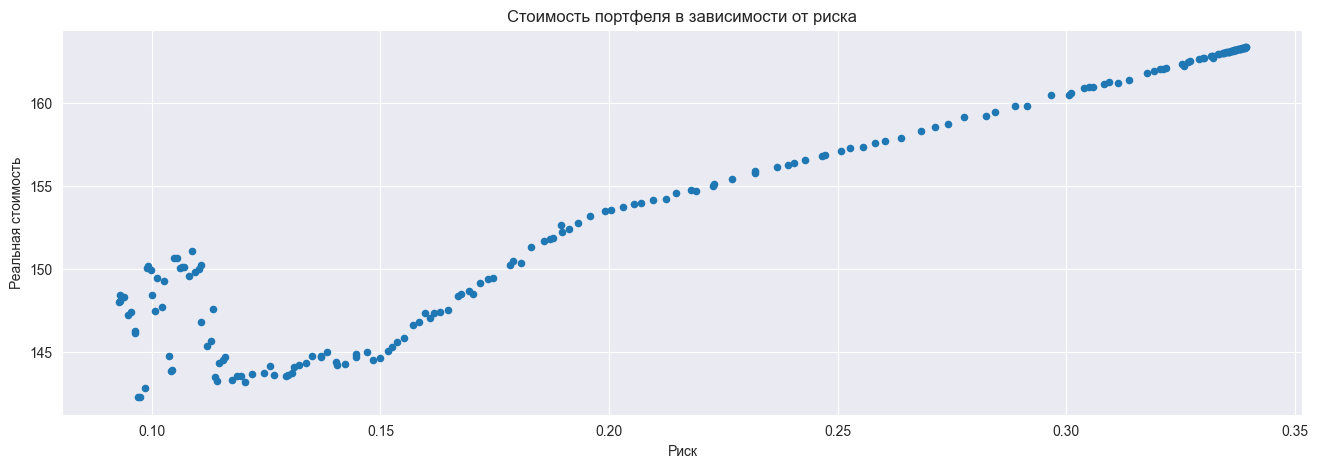

In [57]:
all_data.sort_values(by='end_price', ascending=False)[['risk', 'end_price']]\
    .plot(kind='scatter', x='risk', y='end_price', figsize=(16, 5))
plt.title('Стоимость портфеля в зависимости от риска')
plt.xlabel('Риск')
plt.ylabel('Реальная стоимость')
plt.show()

In [58]:
all_data.sort_values(by='end_price', ascending=False)

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm,end_price
1,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,142.857140,0.339385,NSGA-2,163.32
7,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,142.823818,0.339269,C-TAEA,163.32
43,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,142.818635,0.339252,MOEA/D,163.32
33,0.000,0.999,0.000,0.000,0.001,0.000,0.000,0.000,142.735388,0.338962,MOEA/D,163.30
0,0.000,0.999,0.000,0.000,0.001,0.000,0.000,0.000,142.810617,0.339223,C-TAEA,163.30
...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.039,0.191,0.009,0.002,0.191,0.189,0.188,0.191,-0.506451,0.114284,NSGA-2,143.25
29,0.000,0.212,0.001,0.000,0.210,0.185,0.207,0.183,12.874921,0.120442,NSGA-2,143.23
25,0.136,0.148,0.140,0.011,0.149,0.129,0.145,0.143,-49.034910,0.098533,NSGA-2,142.84
102,0.143,0.144,0.144,0.002,0.144,0.136,0.144,0.144,-51.038041,0.097398,NSGA-2,142.31
